In [1]:
import pandas as pd

df = pd.read_parquet("transactions_eda_ready.parquet")

Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import ast
from datetime import time

rates = pd.read_parquet("historical_currency_exchange.parquet")
rates["date"] = pd.to_datetime(rates["date"]).dt.date

# переводим wide -> long: (date, currency, rate)
rate_long = rates.melt(id_vars=["date"], var_name="currency", value_name="rate")


OUTPUT_FILE = "transactions_eda_ready.parquet"
writer = None

BASE_COLS = [
    "transaction_id","timestamp","amount","currency","country","city","city_size",
    "vendor_category","vendor_type","channel","device","card_type",
    "is_card_present","is_outside_home_country","is_high_risk_vendor","is_weekend",
    "last_hour_activity","is_fraud"
]

BATCH_SIZE = 500_000

def parse_last_hour_activity(series):
    """
    Быстрый и максимально безопасный парсинг dict-подобных строк в числовые колонки.
    """
    # Преобразуем каждую строку в dict
    def safe_parse(x):
        try:
            if isinstance(x, dict):
                return x
            return ast.literal_eval(x)
        except Exception:
            return {}
    parsed = series.map(safe_parse)

    def extract(key, default=np.nan):
        return parsed.map(lambda d: d.get(key, default))

    return pd.DataFrame({
        "lha_num_transactions": extract("num_transactions"),
        "lha_total_amount": extract("total_amount"),
        "lha_unique_merchants": extract("unique_merchants"),
        "lha_unique_countries": extract("unique_countries"),
        "lha_max_single_amount": extract("max_single_amount"),
    })

def memory_downcast(df):
    """
    Экономия памяти: даункаст чисел, категориальные → category.
    """
    for c in df.select_dtypes(include=["int64"]).columns:
        df[c] = pd.to_numeric(df[c], downcast="integer")
    for c in df.select_dtypes(include=["float64"]).columns:
        df[c] = pd.to_numeric(df[c], downcast="float")
    cat_candidates = ["country","city","city_size","vendor_category","vendor_type","channel","device","card_type","currency"]
    for c in cat_candidates:
        if c in df.columns and df[c].dtype == "object":
            df[c] = df[c].astype("category")
    return df

def build_time_features(df):
    """
    Временные фичи из timestamp: date, hour, weekday, is_night.
    """
    ts = pd.to_datetime(df["timestamp"])
    df["date"] = ts.dt.date
    df["hour"] = ts.dt.hour.astype("int16")
    df["weekday"] = ts.dt.weekday.astype("int8")   # 0=Monday
    # ночь: 0..5 часов
    df["is_night"] = df["hour"].isin([0,1,2,3,4,5])
    return df

dataset = ds.dataset("transaction_fraud_data.parquet", format="parquet")

processed_rows = 0
for i, batch in enumerate(dataset.to_batches(columns=BASE_COLS, batch_size=BATCH_SIZE), start=1):
    print(f"Батч {i}: получаем pandas (строк: {batch.num_rows:,})")
    df = batch.to_pandas()

    # Временные фичи
    df = build_time_features(df)

    # Конвертация в USD через merge по (date, currency)
    df = df.merge(rate_long, how="left", on=["date","currency"])
    missing_rate = df["rate"].isna().sum()
    if missing_rate:
        print(f"ВНИМАНИЕ: отсутствует rate у {missing_rate} строк — будут отброшены.")
        df = df.dropna(subset=["rate"])

    df["amount_usd"] = df["amount"] / df["rate"]

    # Парсим last_hour_activity -> числовые колонки
    lha = parse_last_hour_activity(df["last_hour_activity"])
    df = pd.concat([df.drop(columns=["last_hour_activity"]), lha], axis=1)

    df["lha_avg_amount"] = (df["lha_total_amount"] / df["lha_num_transactions"]).replace([np.inf, -np.inf], np.nan)
    df["share_in_last_hour_amount"] = (df["amount"] / df["lha_total_amount"]).replace([np.inf, -np.inf], np.nan)

    df = memory_downcast(df)

    # Оставляем итоговый набор колонок для EDA (широкий, но компактный)
    keep_cols = [
        "transaction_id","timestamp","date","hour","weekday","is_night",
        "amount","currency","rate","amount_usd",
        "country","city","city_size","vendor_category","vendor_type","channel","device","card_type",
        "is_card_present","is_outside_home_country","is_high_risk_vendor","is_weekend",
        "lha_num_transactions","lha_total_amount","lha_unique_merchants","lha_unique_countries","lha_max_single_amount",
        "lha_avg_amount","share_in_last_hour_amount",
        "is_fraud"
    ]
    df = df[keep_cols]

    # Arrow-таблица и по-пакетная запись
    table = pa.Table.from_pandas(df, preserve_index=False)
    if writer is None:
        writer = pq.ParquetWriter(OUTPUT_FILE, table.schema)
    writer.write_table(table)

    processed_rows += len(df)
    print(f"Батч {i} записан. Всего записано строк: {processed_rows:,}")

if writer is not None:
    writer.close()

print(f"\nГотово: создан файл `{OUTPUT_FILE}`.\n")


Батч 1: получаем pandas (строк: 267,277)
Батч 1 записан. Всего записано строк: 267,277
Батч 2: получаем pandas (строк: 267,277)
Батч 2 записан. Всего записано строк: 534,554
Батч 3: получаем pandas (строк: 267,277)
Батч 3 записан. Всего записано строк: 801,831
Батч 4: получаем pandas (строк: 267,277)
Батч 4 записан. Всего записано строк: 1,069,108
Батч 5: получаем pandas (строк: 267,277)
Батч 5 записан. Всего записано строк: 1,336,385
Батч 6: получаем pandas (строк: 267,277)
Батч 6 записан. Всего записано строк: 1,603,662
Батч 7: получаем pandas (строк: 267,277)
Батч 7 записан. Всего записано строк: 1,870,939
Батч 8: получаем pandas (строк: 267,277)
Батч 8 записан. Всего записано строк: 2,138,216
Батч 9: получаем pandas (строк: 267,277)
Батч 9 записан. Всего записано строк: 2,405,493
Батч 10: получаем pandas (строк: 267,277)
Батч 10 записан. Всего записано строк: 2,672,770
Батч 11: получаем pandas (строк: 267,277)
Батч 11 записан. Всего записано строк: 2,940,047
Батч 12: получаем panda

Перед глубокой аналитикой проверяем базовые распределения, чтобы:

* Увидеть отличия fraud и non-fraud по суммам.

* Определить временные паттерны мошенничества.

* Найти страны с повышенным уровнем fraud.

Посмотрим на:

* Распределение суммы транзакций (лог-масштаб) для fraud и non-fraud.

* Почасовой паттерн частоты fraud.

* Топ-10 стран по доле мошенничества.

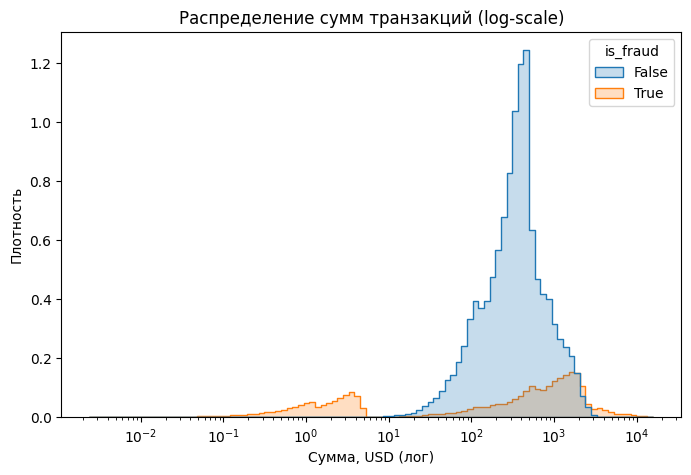

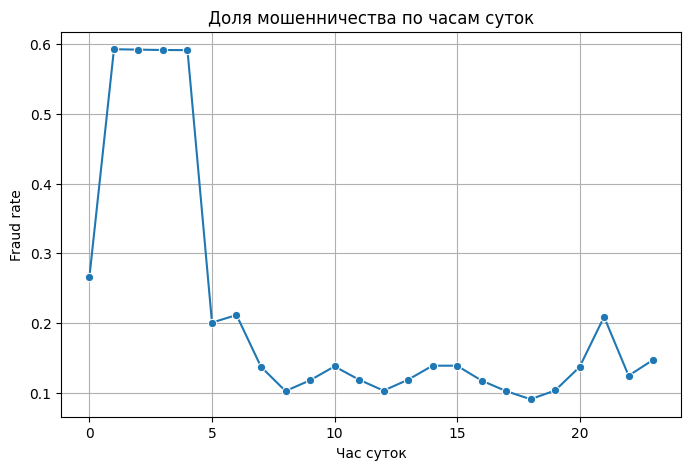

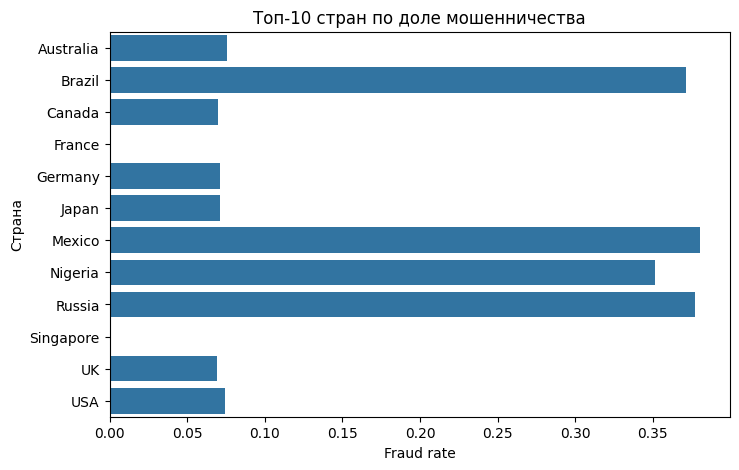

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем подготовленный датасет
df = pd.read_parquet("transactions_eda_ready.parquet")

# 1. Распределение суммы транзакций (log)
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="amount_usd", hue="is_fraud", bins=100, log_scale=True, element="step", stat="density")
plt.title("Распределение сумм транзакций (log-scale)")
plt.xlabel("Сумма, USD (лог)")
plt.ylabel("Плотность")
plt.show()

# 2. Почасовой паттерн fraud-rate
hourly_fraud = df.groupby("hour", observed=True)["is_fraud"].mean().reset_index()
plt.figure(figsize=(8,5))
sns.lineplot(data=hourly_fraud, x="hour", y="is_fraud", marker="o")
plt.title("Доля мошенничества по часам суток")
plt.ylabel("Fraud rate")
plt.xlabel("Час суток")
plt.grid(True)
plt.show()

# 3. Топ-10 стран по fraud-rate
country_fraud = df.groupby("country", observed=True)["is_fraud"].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=country_fraud.values, y=country_fraud.index)
plt.title("Топ-10 стран по доле мошенничества")
plt.xlabel("Fraud rate")
plt.ylabel("Страна")
plt.show()


### Суммы транзакций 

- Мошеннические операции чаще встречаются в двух диапазонах: микросуммы (1–10 USD) и средние суммы (100–1000 USD).

- Честные транзакции сосредоточены в относительно узком диапазоне 100–1000 USD.

- Кластер микросумм среди fraud-транзакций может указывать на «тестовые» операции злоумышленников перед проведением крупных списаний.

### Паттерн по времени суток

- Наблюдается выраженный пик мошенничества с 1 до 4 часов ночи (fraud rate ≈ 60%).

- После 5 утра доля мошеннических транзакций резко падает до 10–20% и остаётся стабильной.

- Такой паттерн может быть связан с работой злоумышленников в определённом часовом поясе или сниженными возможностями мониторинга в это время.

### Страны

- По уровню fraud-rate страны делятся на две отчётливые группы:

- Группа высокого риска (>30%): Бразилия, Мексика, Россия, Нигерия.

- Группа умеренного риска (≈5–10%): Австралия, Канада, Франция, Германия, Япония, Великобритания, США.

- Высокая концентрация мошеннических транзакций в 4 странах может указывать на локализованные схемы или слабый контроль в этих регионах.

### Смотрим как страна и час суток взаимосвязаны в паттернах мошенничества, используя тепловую карту

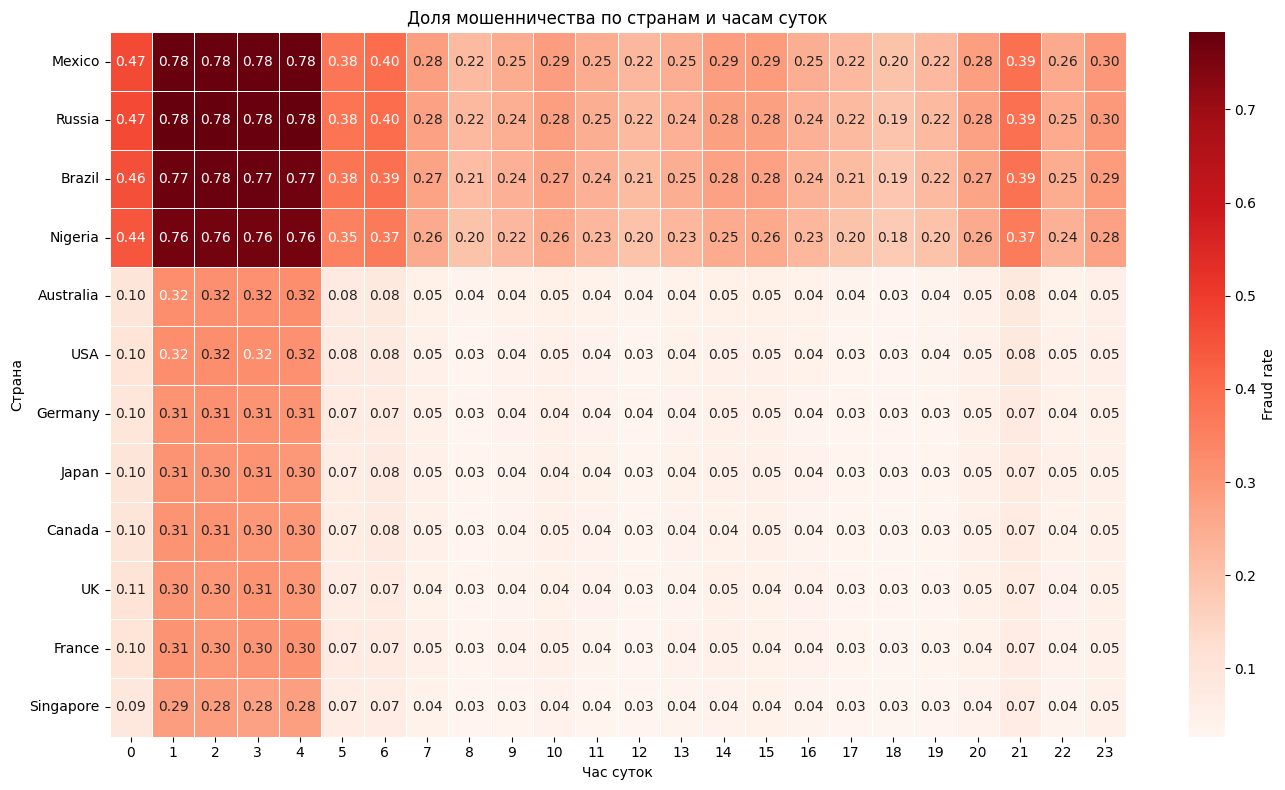

In [6]:
# Группируем по стране и часу, считаем среднюю долю мошенничества
fraud_pivot = (
    df.groupby(["country", "hour"], observed=True)["is_fraud"]
      .mean()
      .reset_index()
      .pivot(index="country", columns="hour", values="is_fraud")
)

# Сортируем страны по среднему уровню мошенничества
fraud_pivot = fraud_pivot.loc[fraud_pivot.mean(axis=1).sort_values(ascending=False).index]

# Построение heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    fraud_pivot,
    cmap="Reds",
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "Fraud rate"},
    linewidths=0.5
)

plt.title("Доля мошенничества по странам и часам суток")
plt.xlabel("Час суток")
plt.ylabel("Страна")
plt.tight_layout()
plt.show()

Анализ тепловой карты показывает, что страны чётко делятся на две группы по характеру распределения мошеннических транзакций в течение суток.

Группа A (Mexico, Russia, Brazil, Nigeria) характеризуется стабильно высоким уровнем мошенничества на протяжении всего дня (0.20–0.78) с максимальными значениями в ночные часы (0.76–0.78). Это может указывать на постоянную активность мошенников и/или недостаточный уровень контроля в эти страны.

Группа B (остальные страны) демонстрирует низкий дневной уровень (0.03–0.08) и резкий рост ночью (0.28–0.32), что говорит о локальных временных уязвимостях — например, ночных периодах снижения мониторинга.

Также странно, что для стран, таких как Россия и Бразилия у которых разные часовые пояса в одно и тоже время наблюдается пик мошеннических транзакций. Первая мысль, которая приходит в голову, что это группа людей, которая пытается обходить антифрод системы путем манипуляций с геолокацией. Хотя если смотреть на всю heatmap то скорее всего это не так.

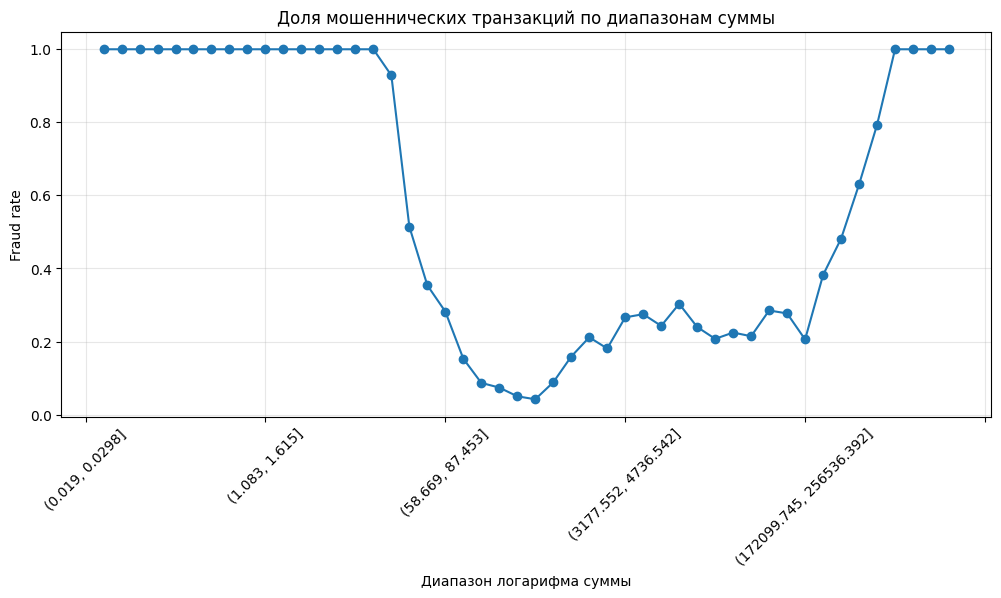

In [24]:
bins = np.logspace(np.log10(df["amount"].min()+0.01), np.log10(df["amount"].max()), 50)
df["amount_bin"] = pd.cut(df["amount"], bins=bins, include_lowest=True)
# Доля мошенничества по бинам
fraud_by_amount = df.groupby("amount_bin", observed=False)["is_fraud"].mean()

plt.figure(figsize=(12,5))
fraud_by_amount.plot(marker="o")
plt.title("Доля мошеннических транзакций по диапазонам суммы")
plt.xlabel("Диапазон логарифма суммы")
plt.ylabel("Fraud rate")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

Есть три ярко выраженных диапазона сумм: 

- мошеннеческие очень маленькие (1–15 USD) и очень большие (от ~10⁶ USD и выше).

- в диапазоне примерно 15–100 USD доля мошенничества резко падает с ~50% до ~10%.

- в диапазоне 100–1 000 USD уровень мошенничества минимален (менее 5%), что может говорить о том, что это «нормальные» для системы суммы.

- После 1 000 USD доля мошенничества снова начинает медленно расти, а ближе к экстремальным суммам (>10⁶ USD) она достигает почти 100%.

Таким образом, распределение по суммам сильно сегментировано: низкие и очень высокие суммы — почти всегда мошенничество;

средние суммы — в основном честные транзакции.

### Расмотрим как распределяется доля мошеннических транзакций в зависимости от двух факторов:

* Тип продавца (vendor_type) — позволяет понять, в каких сегментах рынка мошенники действуют активнее.

* Канал оплаты (channel) — показывает, какие способы совершения транзакций наиболее подвержены мошенничеству.

Такой анализ помогает выявить потенциально уязвимые точки в системе.

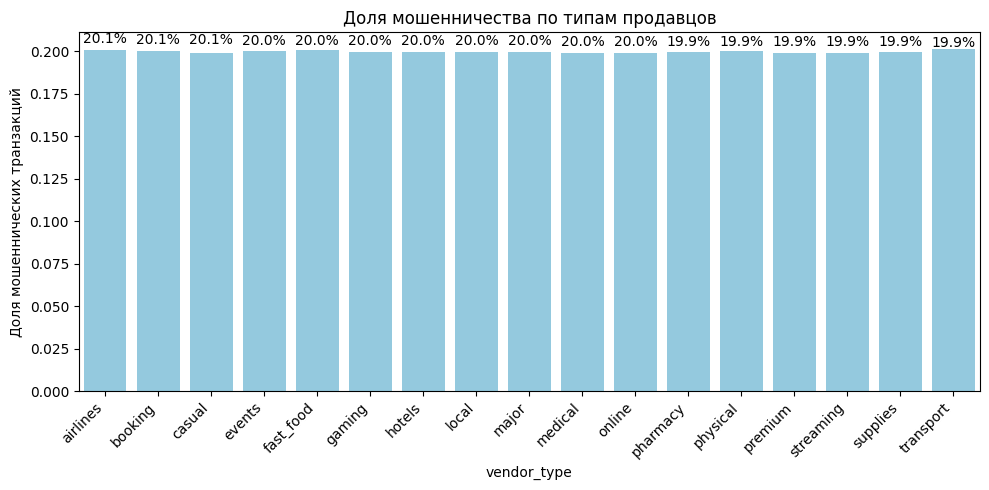

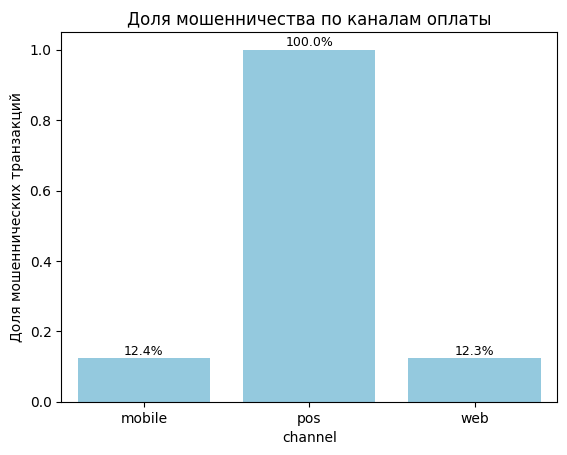

In [27]:
# --- Доля мошенничества по типам продавцов ---
fraud_by_vendor = df.groupby("vendor_type", observed=True)["is_fraud"].mean().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=fraud_by_vendor.index, y=fraud_by_vendor.values, color="skyblue")  # однотонный цвет
plt.title("Доля мошенничества по типам продавцов")
plt.ylabel("Доля мошеннических транзакций")
plt.xticks(rotation=45, ha="right")

for i, val in enumerate(fraud_by_vendor.values):
    plt.text(i, val + 0.002, f"{val:.1%}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


# --- График по каналам оплаты  ---
channel_order = ["mobile", "pos", "web"]
fraud_by_channel = (
    df.groupby("channel", observed=True)["is_fraud"]
    .mean()
    .reindex(channel_order)
)

sns.barplot(
    x=fraud_by_channel.index,
    y=fraud_by_channel.values,
    color="skyblue"
)
plt.title("Доля мошенничества по каналам оплаты")
plt.ylabel("Доля мошеннических транзакций")
for i, v in enumerate(fraud_by_channel.values):
    plt.text(i, v + 0.01, f"{v:.1%}", ha="center", fontsize=9)
plt.show()

* Тип продавца: уровень мошенничества почти одинаков во всех категориях (~20%), что говорит об отсутствии явной концентрации мошенников в определённых сегментах.
Это может означать, что мошенники действуют достаточно равномерно во всех типах торговых точек.

* Канал оплаты: здесь наблюдается контраст — для pos зафиксирован 100% уровень мошенничества (вероятно, из-за малой выборки и специфики атак), а mobile и web имеют значительно меньшую долю (~12%). Это указывает на необходимость детального изучения мобильных транзакций, так как они могут быть точкой основного риска.

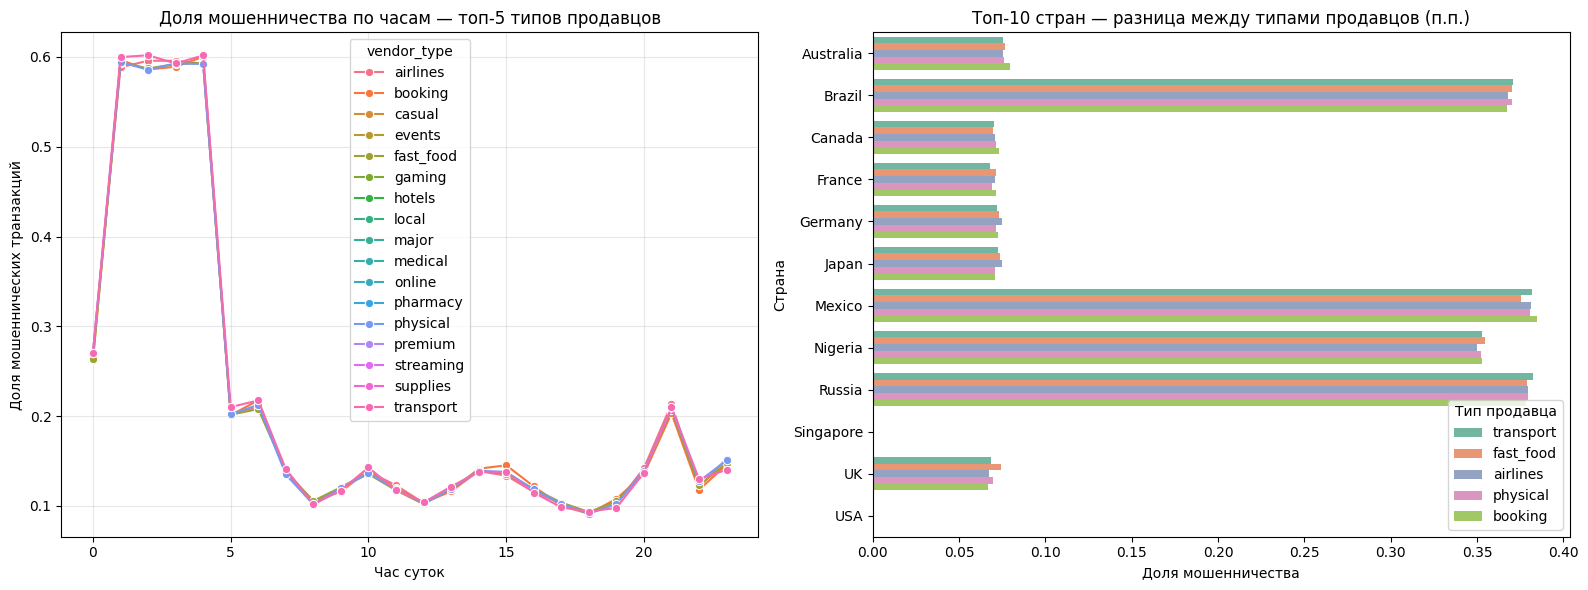

In [ ]:
top5_vendor_types = (
    df.groupby("vendor_type", observed=True)["is_fraud"]
      .mean()
      .sort_values(ascending=False)
      .head(5)
      .index
)

# фильтруем только топ-5
df_top5 = df[df["vendor_type"].isin(top5_vendor_types)].copy()

fraud_by_hour_vendor = (
    df_top5.groupby(["hour", "vendor_type"], observed=True)["is_fraud"]
           .mean()
           .reset_index()
)

agg_country_vendor = (
    df_top5.groupby(["country", "vendor_type"], observed=True)["is_fraud"]
           .agg(rate="mean", count="count")
           .reset_index()
)

# широкой формой: строки — страны, колонки — типы продавцов
wide_country_vendor = agg_country_vendor.pivot(index="country", columns="vendor_type", values="rate").reset_index()
wide_country_vendor.columns.name = None

wide_country_vendor["delta_pp"] = (wide_country_vendor[top5_vendor_types].max(axis=1) - 
                                   wide_country_vendor[top5_vendor_types].min(axis=1)) * 100

# топ-10 стран по модулю разницы
top_countries_vendor = wide_country_vendor.sort_values(by="delta_pp", key=np.abs, ascending=False).head(10)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(
    data=fraud_by_hour_vendor,
    x="hour", y="is_fraud", hue="vendor_type", marker="o",
    ax=axes[0]
)
axes[0].set_title("Доля мошенничества по часам — топ-5 типов продавцов")
axes[0].set_xlabel("Час суток")
axes[0].set_ylabel("Доля мошеннических транзакций")
axes[0].grid(True, alpha=0.3)
axes[0].legend(title="Тип продавца")

# --- Правый график: топ-10 стран по разнице ---
sns.barplot(
    data=top_countries_vendor.melt(id_vars="country", value_vars=top5_vendor_types),
    x="value", y="country", hue="variable", ax=axes[1], palette="Set2"
)
axes[1].set_title("Топ-10 стран — разница между типами продавцов (п.п.)")
axes[1].set_xlabel("Доля мошенничества")
axes[1].set_ylabel("Страна")
axes[1].legend(title="Тип продавца")

plt.tight_layout()
plt.show()


На левом графике линии типов продавцов практически совпали (web "накрывает" mobile). значит, по часам сутки у цифровых каналов поведение почти одинаковое. И на графике справа тоже видно, что по странам у типов продавцов поведение почти одинаковое.

### Небольшой анализ pos

In [28]:
channel_stats = (
    df.groupby("channel", observed=True)["is_fraud"]
    .agg(["count", "mean"])
    .rename(columns={"count": "transactions", "mean": "fraud_share"})
    .sort_values(by="fraud_share", ascending=False)
)

channel_stats["fraud_share"] = channel_stats["fraud_share"].apply(lambda x: f"{x:.2%}")
channel_stats

,transactions,fraud_share
channel,,
pos,651047,100.00%
mobile,2269578,12.39%
web,4563141,12.33%


Анализ показывает, что канал POS имеет 100% долю мошенничества при 651 047 транзакциях. Это выглядит аномально и требует проверки — возможно, в данных этот канал фиксировался только при мошеннических операциях. Mobile и Web имеют примерно одинаковую долю мошенничества (~12%), что выглядит более реалистично.

In [29]:
# 1. Проверка базового распределения
print("Доля мошенничества по каналам")
print(df.groupby("channel", observed=True)["is_fraud"].agg(["count", "mean"]))

# 2. Описание POS транзакций
print("\nОписание POS транзакций")
pos_df = df[df["channel"] == "pos"]
print(pos_df.describe(include="all"))

# 3. Кросс-таблицы с защитой от отсутствия одной из категорий
def fraud_share_table(df, column):
    tab = pd.crosstab(df[column], df["is_fraud"], normalize="index") * 100
    # Гарантируем, что оба столбца будут
    if 0 not in tab.columns:
        tab[0] = 0
    if 1 not in tab.columns:
        tab[1] = 0
    tab = tab[[0, 1]].rename(columns={0: "legit_%", 1: "fraud_%"})
    return tab.sort_values("fraud_%", ascending=False)

print("\nМошенничество по типу продавца (POS)")
print(fraud_share_table(pos_df, "vendor_type"))

print("\nМошенничество по стране (POS)")
print(fraud_share_table(pos_df, "country"))

print("\nМошенничество по устройству (POS)")
print(fraud_share_table(pos_df, "device"))

# 4. Проверка дат
print("\nДиапазон дат для POS")
print(pos_df["date"].min(), "→", pos_df["date"].max())



Доля мошенничества по каналам
           count      mean
channel                   
mobile   2269578  0.123878
pos       651047  1.000000
web      4563141  0.123275

Описание POS транзакций
       transaction_id                   timestamp        date           hour  \
count          651047                      651047      651047  651047.000000   
unique         650999                         NaN          31            NaN   
top       TX_5bcd0c73                         NaN  2024-10-21            NaN   
freq                2                         NaN       21324            NaN   
mean              NaN  2024-10-15 09:09:25.559648         NaN       8.493089   
min               NaN  2024-09-30 00:00:07.105592         NaN       0.000000   
25%               NaN  2024-10-07 15:03:10.760803         NaN       2.000000   
50%               NaN  2024-10-15 06:26:40.457571         NaN       5.000000   
75%               NaN  2024-10-23 03:00:48.468525         NaN      14.000000   
max       

651 тыс. операций за период с 30 сентября по 30 октября 2024 г. вне зависимости от типа устройства — будь то Chip Reader, Magnetic Stripe или NFC Payment. Это крайне аномальная ситуация, которая может быть следствием:

Искусственной разметки данных.

Массового мошеннического инцидента с компрометацией всех типов POS-терминалов в этот период.

Топ-10 стран для POS
            count  mean
country                
Russia     130473   1.0
Brazil     130426   1.0
Nigeria    130044   1.0
Mexico     130032   1.0
Australia   16463   1.0
Japan       16382   1.0
Canada      16265   1.0
Germany     16242   1.0
UK          16204   1.0
USA         16200   1.0

Топ-10 городов для POS
               count  mean
city                      
Unknown City  634847   1.0
Philadelphia    1656   1.0
New York        1651   1.0
San Diego       1644   1.0
Houston         1633   1.0
Chicago         1618   1.0
San Antonio     1616   1.0
San Jose        1616   1.0
Los Angeles     1612   1.0
Phoenix         1595   1.0


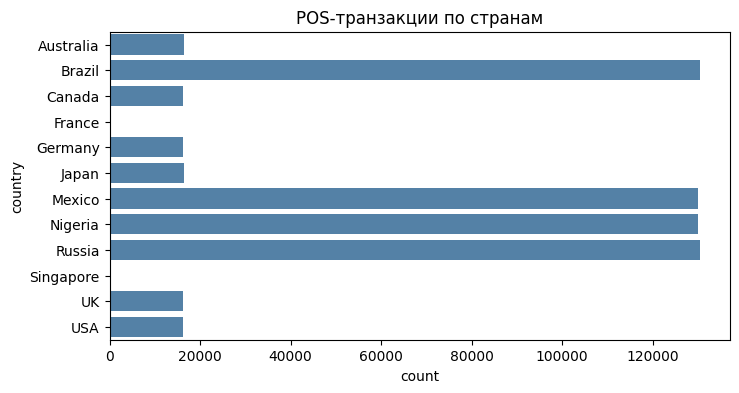

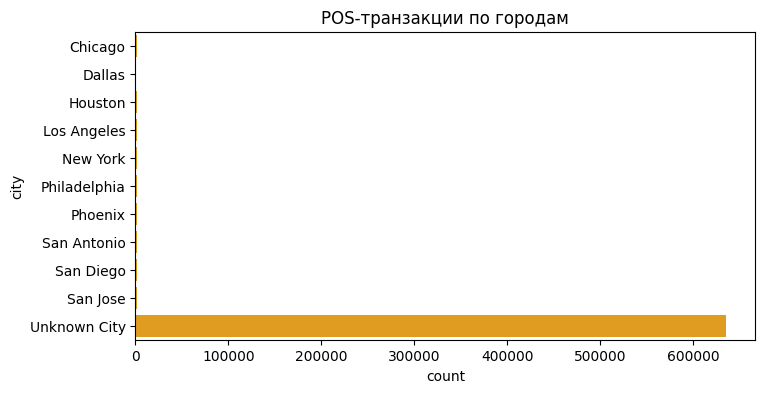

In [30]:
# Фильтруем только POS-транзакции
pos_df = df[df["channel"] == "pos"]

# Топ-10 стран по числу POS-транзакций
pos_country_stats = (
    pos_df.groupby("country", observed=True)["is_fraud"]
    .agg(["count", "mean"])
    .sort_values("count", ascending=False)
    .head(10)
)

# Топ-10 городов по числу POS-транзакций
pos_city_stats = (
    pos_df.groupby("city", observed=True)["is_fraud"]
    .agg(["count", "mean"])
    .sort_values("count", ascending=False)
    .head(10)
)

print("Топ-10 стран для POS")
print(pos_country_stats)

print("\nТоп-10 городов для POS")
print(pos_city_stats)

# Визуализация стран
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.barplot(
    data=pos_country_stats.reset_index(),
    x="count", y="country", color="steelblue"
)
plt.title("POS-транзакции по странам")
plt.show()

# Визуализация городов
plt.figure(figsize=(8,4))
sns.barplot(
    data=pos_city_stats.reset_index(),
    x="count", y="city", color="orange"
)
plt.title("POS-транзакции по городам")
plt.show()


Думаю что дальше pos анализировать нет смысла. Было предположение что это может быть спланированной атакой, но нет.

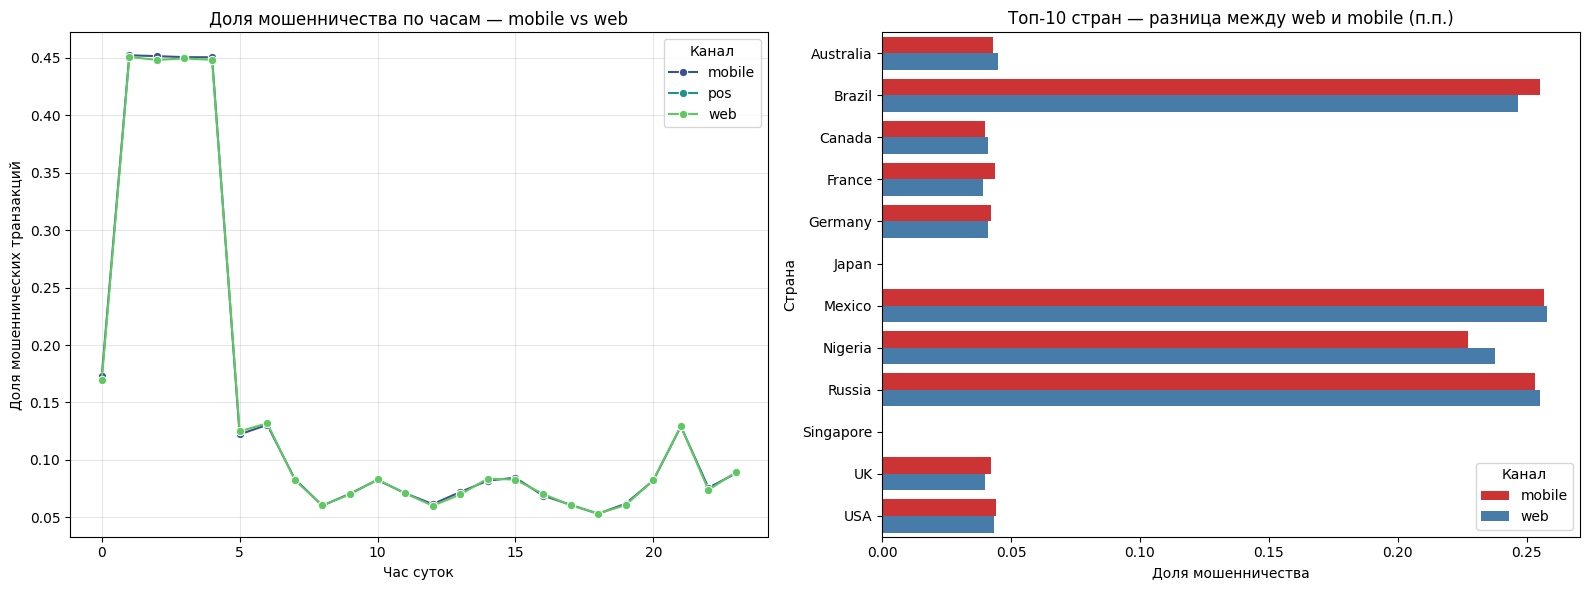

In [ ]:
df_ch = df[df["channel"].isin(["mobile", "web"])].copy()

fraud_by_hour_channel = (
    df_ch.groupby(["hour", "channel"], observed=True)["is_fraud"]
         .mean()
         .reset_index()
)

agg_country_channel = (
    df_ch.groupby(["country", "channel"], observed=True)["is_fraud"]
         .agg(rate="mean", count="count")
         .reset_index()
)

# широкая форма
wide_country_channel = agg_country_channel.pivot(index="country", columns="channel", values="rate").reset_index()
wide_country_channel.columns.name = None

# разница в п.п. между web и mobile
wide_country_channel["delta_pp"] = (wide_country_channel["web"] - wide_country_channel["mobile"]) * 100

# топ-10 стран по модулю разницы
top_countries_channel = wide_country_channel.sort_values(by="delta_pp", key=np.abs, ascending=False).head(10)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(
    data=fraud_by_hour_channel,
    x="hour", y="is_fraud", hue="channel", marker="o",
    ax=axes[0], palette="viridis"
)
axes[0].set_title("Доля мошенничества по часам — mobile vs web")
axes[0].set_xlabel("Час суток")
axes[0].set_ylabel("Доля мошеннических транзакций")
axes[0].grid(True, alpha=0.3)
axes[0].legend(title="Канал")

# --- Правый график: топ-10 стран по разнице ---
sns.barplot(
    data=top_countries_channel.melt(id_vars="country", value_vars=["mobile", "web"]),
    x="value", y="country", hue="variable", ax=axes[1], palette="Set1"
)
axes[1].set_title("Топ-10 стран — разница между web и mobile (п.п.)")
axes[1].set_xlabel("Доля мошенничества")
axes[1].set_ylabel("Страна")
axes[1].legend(title="Канал")

plt.tight_layout()
plt.show()

На левом графике линии web и mobile практически совпали (web "накрывает" mobile). значит, по часам сутки у цифровых каналов поведение почти одинаковое. И на графике справа тоже видно, что по странам у цифровых каналов поведение почти одинаковое.